In [1]:
import pandas as pd
import numpy as np
import time
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

Pour analyser la pertinence du modèle que nous sélectionnerons, nous devons créer une fonction qui pénalise les mauvaises prédiction et plus particulièrement les False Negative. Ce sont des prédictions du modèle qui prédise un 0 alors que nous attendons un 1. Cette prédiction est plus dangereuse pour la pertinence du modèle car si nous prédisons un remboursement probable d'un crédit et que cela n'est pas le cas, cela impacte directement la rentabilité de la banque, ce qui n'est pas souhaitable.

In [2]:
def custom_penalty(y_test, y_pred):
    y_test = y_test.to_numpy().flatten()
    penalty = 0.0
    sum_penalty = 0
    
    for yt, yp in zip(y_test, y_pred):
        if yt == 1 and yp == 0:
            penalty = penalty + 10
            sum_penalty = sum_penalty +1
        elif yt == 0 and yp == 1:
            penalty = penalty + 1
            sum_penalty = sum_penalty +1
            
    score = (penalty/len(y_test))*0.1#/ (sum_penalty + 1e-7) # Prevents zero division
    return score

## Forêt aléatoire

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [4]:
X_train_hybrid = pd.read_csv('X_train_CSV_hybrid.csv')
X_test_hybrid = pd.read_csv('X_test_CSV_hybrid.csv')
y_train_hybrid = pd.read_csv('y_train_CSV_hybrid.csv')
y_test_hybrid = pd.read_csv('y_test_CSV_hybrid.csv')

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hybrid)
X_test_scaled = scaler.transform(X_test_hybrid)

In [6]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [7]:
scores = cross_val_score(random_forest_model, X_train_scaled, y_train_hybrid, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Scores de validation croisée: [-0.30625  -0.311875 -0.32     -0.299375 -0.318125]


In [8]:
start_time = time.time()
random_forest_model.fit(X_train_scaled, y_train_hybrid)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Le temps de traitement est de : 1.4054620265960693 secondes


In [9]:
y_pred_hybrid = random_forest_model.predict(X_test_scaled)

In [10]:
custom_penalty(y_test_hybrid, y_pred_hybrid)

0.21735000000000004

In [11]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test_hybrid, y_pred_hybrid)))

RMSE : 0.54


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_hybrid, y_pred_hybrid)
auc_score_hybrid = roc_auc_score(y_test_hybrid, y_pred_hybrid)
auc_score_hybrid

0.6792077175697866

## Test différents hyper-paramètres pour le modèle de forêt aléatoire

In [10]:
X_train_hybrid = pd.read_csv('X_train_CSV_hybrid.csv')
X_test_hybrid = pd.read_csv('X_test_CSV_hybrid.csv')
y_train_hybrid = pd.read_csv('y_train_CSV_hybrid.csv')
y_test_hybrid = pd.read_csv('y_test_CSV_hybrid.csv')

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hybrid)
X_test_scaled = scaler.transform(X_test_hybrid)

In [12]:
random_forest_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=random_forest_model,\
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_hybrid)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [13]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test_scaled, y_test_hybrid)
print(best_params)
print(best_score)
print(best_model)
print(best_model_score)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.7045
RandomForestClassifier(max_depth=20, min_samples_split=10)
0.703


In [14]:
random_forest_model = RandomForestClassifier(max_depth=20,\
                                             min_samples_leaf=1,\
                                             min_samples_split=10, n_estimators=100)
random_forest_model.fit(X_train_scaled, y_train_hybrid)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=20, min_samples_split=10)

In [15]:
y_pred_hybrid = random_forest_model.predict(X_test_scaled)

In [16]:
custom_penalty(y_test_hybrid, y_pred_hybrid)

0.21105000000000002

In [17]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test_hybrid, y_pred_hybrid)))

RMSE : 0.54


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_hybrid, y_pred_hybrid)
auc_score_hybrid = roc_auc_score(y_test_hybrid, y_pred_hybrid)
auc_score_hybrid

0.6712217107289489

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estim

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimator

In [13]:
X_train_under = pd.read_csv('X_train_CSV_under.csv')
X_test_under = pd.read_csv('X_test_CSV_under.csv')
y_train_under = pd.read_csv('y_train_CSV_under.csv')
y_test_under = pd.read_csv('y_test_CSV_under.csv')

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_under)
X_test_scaled = scaler.transform(X_test_under)

In [21]:
random_forest_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=random_forest_model,\
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_under)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [22]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test_scaled, y_test_under)
print(best_params)
print(best_score)
print(best_model)
print(best_model_score)

{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
0.6821249999999999
RandomForestClassifier(min_samples_leaf=4, n_estimators=200)
0.6815


In [15]:
random_forest_model = RandomForestClassifier(max_depth=None,\
                                             min_samples_leaf=4,\
                                             min_samples_split=2, n_estimators=200)

In [17]:
scores = cross_val_score(random_forest_model, X_train_scaled, y_train_hybrid, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Scores de validation croisée: [-0.4225   -0.42875  -0.425625 -0.42625  -0.425625]


In [16]:
start_time = time.time()
random_forest_model.fit(X_train_scaled, y_train_under)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Le temps de traitement est de : 2.229581117630005 secondes


In [18]:
y_pred_under = random_forest_model.predict(X_test_scaled)

In [19]:
custom_penalty(y_test_under, y_pred_under)

0.17015000000000002

In [20]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test_under, y_pred_under)))

RMSE : 0.56


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_under, y_pred_under)
auc_score_under = roc_auc_score(y_test_under, y_pred_under)
auc_score_under

0.6887629011480032

In [30]:
explainer = shap.Explainer(random_forest_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled, check_additivity=False)

100%|===================| 3991/4000 [05:46<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


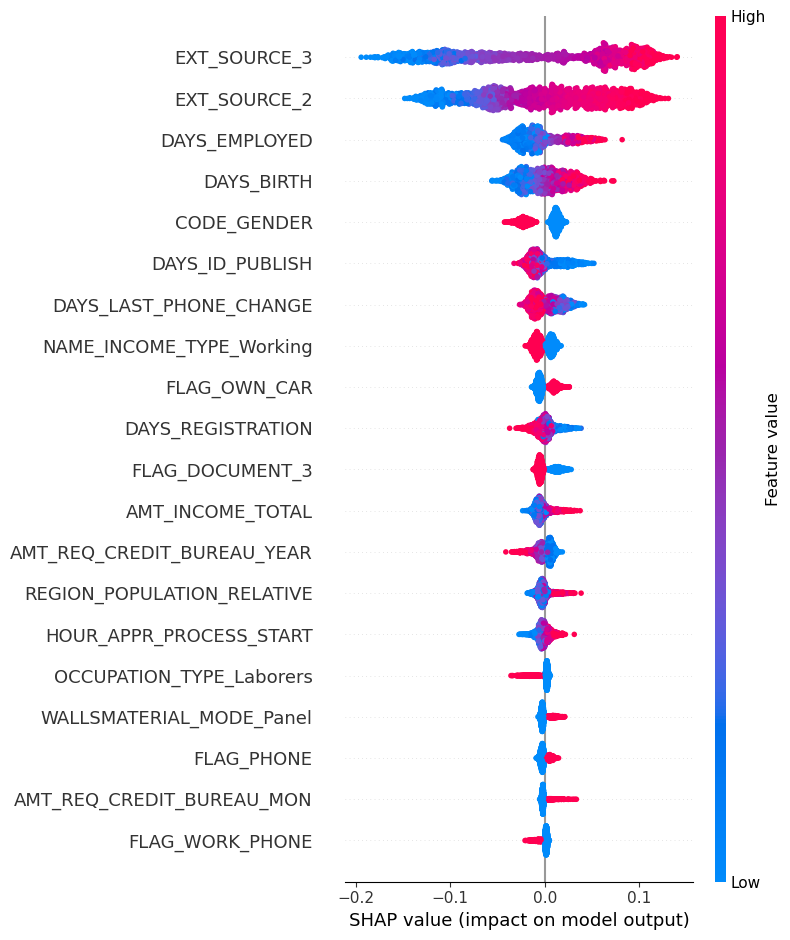

In [40]:
feature_names = X_test_under.columns.tolist()
shap.summary_plot(shap_values[0], X_test_scaled, feature_names=feature_names, show = False)

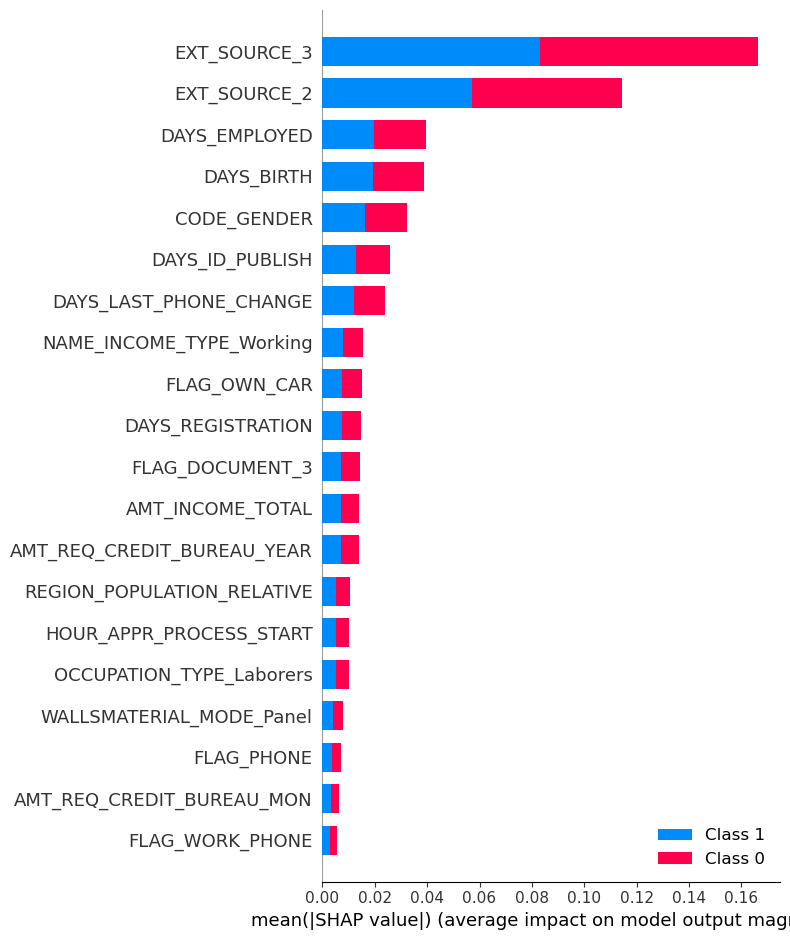

In [41]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=feature_names)